In [ ]:
%%writefile walidacja_funkcji.py
import torch
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, fsolve
import numpy as np

"""
    Zwykly greisen
    Ne(t)= 0.31 / sqrt(ln(E0/Ec)) *  exp[t( 1 - 3/2 ln(s))]
    
    t - distance the shower has developed [radiation length]
    E0 - primary energy (of a particle?)
    Ec - critical energy (of material?)
    Ne(t) - number of particles in electromagnetic shower
    s - shower age, s = 3t / (t + 2 * ln(E0/Ec))
"""

def greisen(t: np.ndarray | float, E0: float = 1e3, Ec: float = 21.8):
    """
        E0 - energia poczatkowa czastki [tutaj w MeV]
        Ec - energia typowa dla materialu [MeV]
    """
    beta0 = np.log(E0 / Ec)
    if isinstance(t, float):
        if t < 0.:
            return 0.0
        else:
            s = 3*t /(t + 2*beta0)
            return 0.31 / np.sqrt(beta0) * np.exp(t * (1 - 1.5 * np.log(s)))
    else:
        valid = t > 0
        result = np.zeros_like(t, dtype=float) # jak t nie ma sensu fizycznego to 0
        
        if np.any(valid):
            t_valid = t[valid]
            s = 3*t_valid / (t_valid + 2*beta0)
            result[valid] = 0.31 / np.sqrt(beta0) * np.exp(t_valid * (1 - 1.5 * np.log(s)))
        
        return result


# @jit(nopython=True)
def NKG(r: float, r_m: float = 79, s: float = 1, r_min: float = 1):
    """
    r - distance from the main axis
    r_m - Molier radius: for earth 79 meters at the sea level or 91 meters above the ground
    s - shower age allegedly 0 < s < 2 but the maximum is for s = 1
    r_min - a point where equation stops working
    r_max - where the equation stops working, 2 * r_m
    """
    r_max = 2 * r_m

    if r < 0.0:
        return 0.0
    if r < r_min:
        r = r_min
    if r > r_max:
        r = r_max
    r_ratio = r / r_m
    return (r_ratio) ** (s - 2) * (1 + r_ratio) ** (s - 4.5)

"""
    s = 3/(1 + 2ln(E0/eps0)/t)
    ale t - vertical depth - funkcja 3 katow tak naprawde
    eps0 = 84 MeV - incident energy
    E0 - energia krytyczna zaloze sobie 1GeV
    Zakladajac najczestsza wartosc s = 1 => 2ln(E0/eps0)/t = 2
    A zatem wliczajac w to katy
    s = 3/(1 + 2cos(theta) * (1 - tan(a) tan(theta) cos(phi)))
"""

def NKG_torch(r:torch.Tensor, s:torch.Tensor=1, r_m:torch.Tensor=79, r_min:torch.Tensor=1):
    r_max = 2 * r_m
    r_ratio = torch.clamp(r, r_min, r_max) / r_m
    return torch.pow(r_ratio, s - 2) * torch.pow(1 + r_ratio, s - 4.5)


def NKG_np(r: float, s: float = 1, r_m: float = 79, r_min: float = 1):
    r_max = 2 * r_m
    r_ratio = np.clip(r, r_min, r_max) / r_m
    return np.power(r_ratio, s - 2) * np.power(1 + r_ratio, s - 4.5)


def jakis_rozklad(x):
    return np.exp(-(3 * x**4 - 2 * x**2))


def metropolis_hastings_probing(distribution: callable, length: int):
    x_actual = 0.1
    xs = np.zeros(length)
    ys = np.zeros(length)
    added = 0

    while added < length:
        x_proposed = x_actual + np.random.normal(loc=0, scale=1)
        ys[added] = distribution(x_proposed)
        prob_adding = ys[added] / distribution(x_actual) # te rozklady nie zaleza od polozenia poprzedniego punktu

        if np.random.uniform(low=0., high=1.) <= prob_adding: # w teorii powinno byc min(1, prob_adding) ale to nic nie zmienia w praktyce
            x_actual = x_proposed
        else:
            ys[added] = ys[added-1]
        xs[added] = x_actual
        added += 1

    return xs, ys

class rs_prober_NKG:
    def __init__(self, epsilon=0.1, looking_x_left=-1, looking_x_right=1, from_x=0, theta=None, alpha=None, phi=None):
        device = 'cuda'
        self.s = torch.tensor(1.0, device=device, dtype=torch.float16)
        self.r_m = torch.tensor(79.0, device=device, dtype=torch.float16)
        
        if None not in (theta, alpha, phi):
            angle_part = np.cos(theta) * (1 - np.tan(alpha) * np.tan(theta) * np.cos(phi)) 
            self.s = torch.tensor(3 / (1 + 2 * angle_part), device=device, dtype=torch.float16)
            self.r_m = torch.tensor(angle_part * 79, device=device, dtype=torch.float16)
        
        minimized = minimize_scalar(lambda x: -NKG_np(x, self.s.cpu().item(), self.r_m.cpu().item()), method='brent')
        self.max_cache = torch.tensor(-minimized.fun, device=device, dtype=torch.float16)
        
        self.from_x = torch.tensor(
            fsolve(lambda x: NKG_np(x, self.s.cpu().item(), self.r_m.cpu().item()) - epsilon, looking_x_left)[0],
            device=device,
            dtype=torch.float16
        )
        self.to_x = torch.tensor(
            fsolve(lambda x: NKG_np(x, self.s.cpu().item(), self.r_m.cpu().item()) - epsilon, looking_x_right)[0],
            device=device, 
            dtype=torch.float16
        )
        
    def rejection_sampling(self, length: int):
        with torch.no_grad():
            xs = torch.empty(length) # preallocated tensor
            filled = 0
            x_dist = torch.distributions.Uniform(low=self.from_x, high=self.to_x)
            u_dist = torch.distributions.Uniform(0, self.max_cache)

            while filled < length:
                X = x_dist.sample((length,)).cuda()
                u = u_dist.sample((length,)).cuda()
                samples = X[u <= NKG_torch(X, self.s, self.r_m)] # zgaduje ze to jest super kosztowne
                
                n_samples = min(len(samples), length - filled)
                xs[filled:filled + n_samples] = samples[:n_samples]
                filled += n_samples
                
            return xs

Overwriting walidacja_funkcji.py


Liczba probek metropolis=1000000, rejection-sampling=1000000


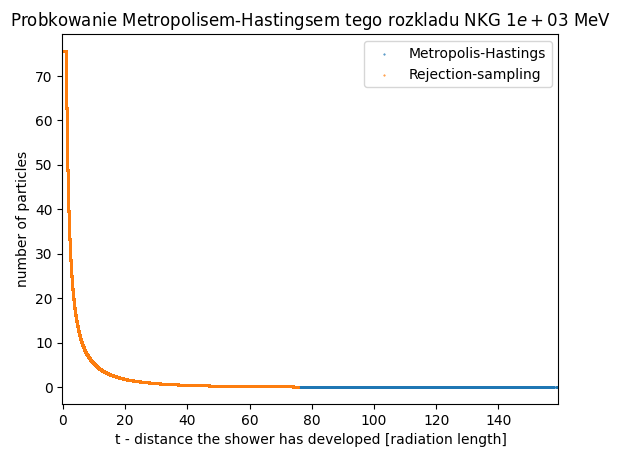

<Figure size 640x480 with 0 Axes>

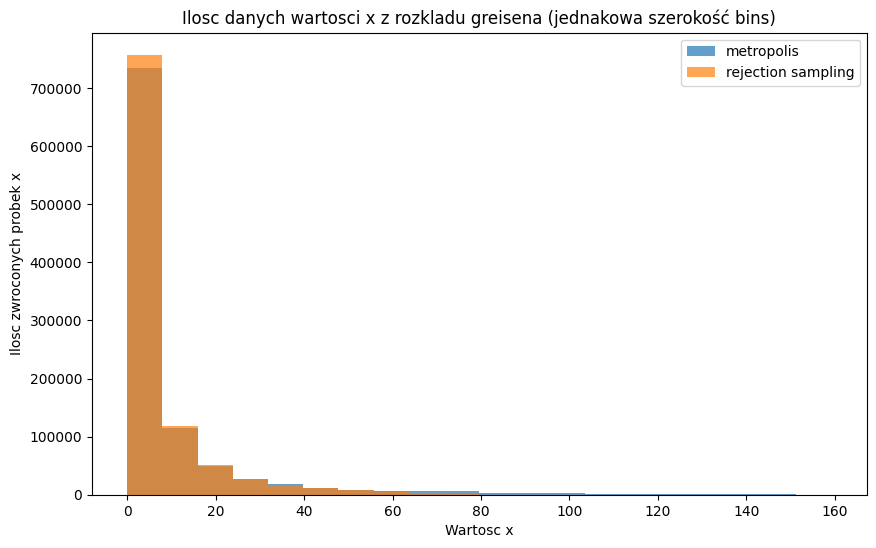

Minimal value from mh = 9.660266193645128e-07, from rs = 2.964342704426483e-06
Maximum value from mh = 159.28035481884203, from rs = 75.50684730279275


In [2]:
from walidacja_funkcji import *

prober = rs_prober_NKG(0.1, -1, 1, from_x=0)

x_mh, y_mh = metropolis_hastings_probing(NKG, 1_000_000)
x_rs = prober.rejection_sampling(1_000_000)
y_rs = NKG_np(x_rs)

print(f'Liczba probek metropolis={len(x_mh)}, rejection-sampling={len(x_rs)}')

plt.title(rf'Probkowanie Metropolisem-Hastingsem tego rozkladu NKG ${1e3:.0e}$ MeV')
plt.scatter(x_mh, y_mh, s=0.2, label='Metropolis-Hastings')
plt.scatter(x_rs, y_rs, s=0.2, label='Rejection-sampling')
plt.xlabel('t - distance the shower has developed [radiation length]')
plt.ylabel('number of particles')
plt.legend()
plt.xlim(-0.1, max(np.max(x_mh), np.max(x_rs)))
plt.show()
plt.savefig('./Wykresy/Walidacja/NKG_z_mh_rs.jpg')

plt.figure(figsize=(10, 6))
plt.title('Ilosc danych wartosci x z rozkladu greisena (jednakowa szerokość bins)')

# Define common range and bins
x_min = min(np.min(x_mh), np.min(x_rs))
x_max = max(np.max(x_mh), np.max(x_rs))
bins = np.linspace(x_min, x_max, 21)  # 21 edges = 20 bins

plt.hist(x_mh, bins=bins, label='metropolis', alpha=0.7)
plt.hist(x_rs, bins=bins, label='rejection sampling', alpha=0.7)
plt.legend()
plt.xlabel('Wartosc x')
plt.ylabel('Ilosc zwroconych probek x')
plt.savefig('./Wykresy/Walidacja/czestosc_dla_NKG_solution1.jpg')
plt.show()


print(f'Minimal value from mh = {np.min(x_mh)}, from rs = {np.min(x_rs)}')
print(f'Maximum value from mh = {np.max(x_mh)}, from rs = {np.max(x_rs)}')

In [3]:
from walidacja_funkcji import *

X0 = 1.757 # cm https://pdg.web.cern.ch/pdg/2020/AtomicNuclearProperties/HTML/iron_Fe.html

x_mh, y_mh = metropolis_hastings_probing(jakis_rozklad, 10_000)
x_rs, y_rs = rejection_sampling_probing(jakis_rozklad, 10_000, 0.01)

print(f'{len(x_rs)=}, {len(x_mh)=}')

plt.title(r'Porownanie metropolisa-hastingsa i rejection-sampling dla $y = e^{-(3x^4 - 2x^2)}$')
plt.scatter(x_mh, y_mh, label='Metropolis-Hastings', s=1)
plt.scatter(x_rs, y_rs, label='Rejection-sampling', s=1)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('./Wykresy/Walidacja/porownanie_moj_rozklad.jpg')

plt.figure()
plt.title('Ilosc probek danego x z metropolisa-hastingsa i rejection-sampling')
plt.hist(x_mh, bins=50, label='metropolis')
plt.hist(x_rs, bins=50, label='rejection-sampling', alpha=0.85)
plt.legend()
plt.xlabel('Wartosc')
plt.ylabel('Ilosc probek')
plt.savefig('./Wykresy/Walidacja/porownanie_moj_rozklad_histogram.jpg')

NameError: name 'rejection_sampling_probing' is not defined

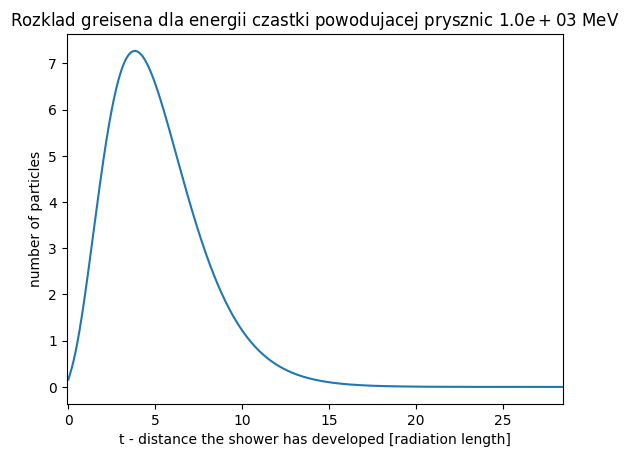

In [ ]:
t_prob = np.linspace(1e-10, 50, num=10_000) / X0 # jak daleko przeszedl dzielone przez dlugosc radiacyjna dla zelaza
values = greisen(t_prob)

plt.title(rf'Rozklad greisena dla energii czastki powodujacej prysznic ${1e3:.1e}$ MeV')
plt.plot(t_prob, values)
plt.xlabel('t - distance the shower has developed [radiation length]')
plt.ylabel('number of particles')
plt.xlim(-0.1, np.max(t_prob))
plt.savefig('./Wykresy/Walidacja/Rozklad_Greisena.jpg')

In [ ]:
x_mh, y_mh = metropolis_hastings_probing(greisen, 10_000)
x_rs, y_rs = rejection_sampling_probing(greisen, 10_000, 0.1)

print(f'Liczba probek metropolis={len(x_mh)}, rejection-sampling={len(x_rs)}')

plt.title(rf'Probkowanie Metropolisem-Hastingsem tego rozkladu greisena ${1e3:.0e}$ MeV')
plt.scatter(x_mh, y_mh, s=0.2, label='Metropolis-Hastings')
plt.scatter(x_rs, y_rs, s=0.2, label='Rejection-sampling')
plt.xlabel('t - distance the shower has developed [radiation length]')
plt.ylabel('number of particles')
plt.legend()
plt.xlim(-0.1, max(np.max(x_mh), np.max(x_rs)))
plt.savefig('./Wykresy/Walidacja/greisen_z_rs_i_mh.jpg')

plt.title('Ilosc danych wartosci x z rozkladu greisena, jakie zwrocila metoda')
plt.hist(x_mh, bins=20, label='metropolis')
plt.hist(x_rs, bins=20, label='rejection sampling', alpha=0.85)
plt.legend()
plt.xlabel('Wartosc x')
plt.ylabel('Ilosc zwroconych probek x')
plt.savefig('./Wykresy/Walidacja/czestosc_x_dla_greisena.jpg')

NameError: name 'rejection_sampling_probing' is not defined

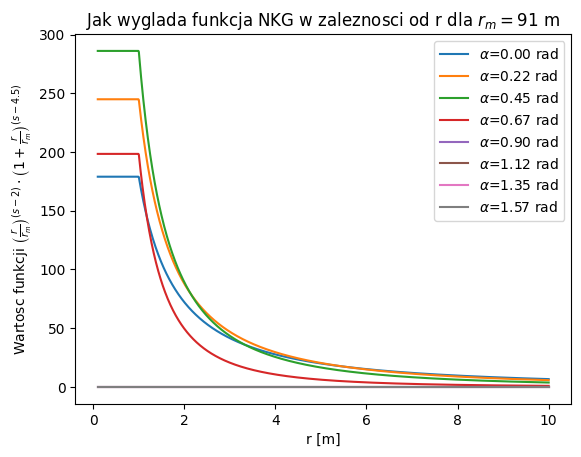

In [4]:
r_m = 91 
rs = np.linspace(0.1, 10, num=1_000)
s = 1

f = []

"""
    alpha - independent of z
    theta 
"""

alphas = np.linspace(0, np.pi / 2., num=8)
theta = 0.7
phi = 0.0

for alpha in alphas:
    f.append([])
    for r in rs:
        angle_part = np.cos(theta) * (1 - np.tan(alpha) * np.tan(theta) * np.cos(phi))
        r_current_m = angle_part * r_m
        s_current = angle_part * s
        f[-1].append( NKG(r, r_current_m, s_current) )

f = np.array(f)
plt.title(r'Jak wyglada funkcja NKG w zaleznosci od r dla $r_m = 91$ m')
plt.xlabel('r [m]')
plt.ylabel(r'Wartosc funkcji $\left(\frac{r}{r_m}\right)^{(s - 2)} \cdot \left(1 + \frac{r}{r_m}\right)^{(s - 4.5)}$')
for i, alpha in enumerate(alphas):
    plt.plot(rs, f[i], label=rf'$\alpha$={alpha:.2f} rad')
plt.legend()
plt.savefig('./Wykresy/Walidacja/NKG.jpg')